# Santa Tree Packing Optimization

## 0. Notebook Dependencies

In [1]:
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
from shapely import affinity, touches
from shapely.geometry import Polygon
from shapely.ops import unary_union
from shapely.strtree import STRtree
from decimal import Decimal, getcontext


## 1. Business Understanding

* Minimize the average square area per tree by optimally placing and rotating tree shapes inside the smallest possible square, across multiple configurations.

**Success Metric:**

$$ \text{Total Score} = \sum_{puzzles} \frac{s^2}{n} $$

Where:

$s$ = side length of minimal bounding square

$n$ = number of trees in that puzzle

**Hard Constraints:**

- No overlapping trees

- All trees must lie within coordinate bounds

- Output format must follow Kaggle spec

**Optimization Mindset:**

- Feasibility first, tightness second.

## 2. Data Understanding


### 2.1 Dataset Overview

- Each puzzle contains n ∈ [1, 200] trees

- Tree geometry is fixed (same shape across puzzles)

- Output requires (x, y, rotation) per tree

### 2.2 What We Do Not Learn From Data

- No labels

- No training signal

- No prediction task

- This is a pure optimization problem, not ML.

## 3. Modelling Assumptions

**Assumptions:**
- Trees are modeled as 2D convex polygons (triangles)
- Trees can be freely rotated
- Reference point is polygon centroid
- Bounding square is axis-aligned
- Objective depends only on max x/y extent

## 4. Geometry Layer (Core Abstraction)

### 4.1 Tree Shape Definition.

* First we need to design the base tree

In [20]:
# Set high precision for Decimal calculations

getcontext().prec = 25
scale_factor = Decimal('1')

# Create the ChristmasTree class
class ChristmasTree:
    """Represents a single, rotatable Christmas tree of a fixed size."""

    def __init__(self, center_x='0', center_y='0', angle='0'):
        """Initializes the Christmas tree with a specific position and rotation."""
        self.center_x = Decimal(center_x)
        self.center_y = Decimal(center_y)
        self.angle = Decimal(angle)

        trunk_w = Decimal('0.15')
        trunk_h = Decimal('0.2')
        base_w = Decimal('0.7')
        mid_w = Decimal('0.4')
        top_w = Decimal('0.25')
        tip_y = Decimal('0.8')
        tier_1_y = Decimal('0.5')
        tier_2_y = Decimal('0.25')
        base_y = Decimal('0.0')
        trunk_bottom_y = -trunk_h

        initial_polygon = Polygon(
            [
                # Start at Tip
                (Decimal('0.0') * scale_factor, tip_y * scale_factor),
                # Right side - Top Tier
                (top_w / Decimal('2') * scale_factor, tier_1_y * scale_factor),
                (top_w / Decimal('4') * scale_factor, tier_1_y * scale_factor),
                # Right side - Middle Tier
                (mid_w / Decimal('2') * scale_factor, tier_2_y * scale_factor),
                (mid_w / Decimal('4') * scale_factor, tier_2_y * scale_factor),
                # Right side - Bottom Tier
                (base_w / Decimal('2') * scale_factor, base_y * scale_factor),
                # Right Trunk
                (trunk_w / Decimal('2') * scale_factor, base_y * scale_factor),
                (trunk_w / Decimal('2') * scale_factor, trunk_bottom_y * scale_factor),
                # Left Trunk
                (-(trunk_w / Decimal('2')) * scale_factor, trunk_bottom_y * scale_factor),
                (-(trunk_w / Decimal('2')) * scale_factor, base_y * scale_factor),
                # Left side - Bottom Tier
                (-(base_w / Decimal('2')) * scale_factor, base_y * scale_factor),
                # Left side - Middle Tier
                (-(mid_w / Decimal('4')) * scale_factor, tier_2_y * scale_factor),
                (-(mid_w / Decimal('2')) * scale_factor, tier_2_y * scale_factor),
                # Left side - Top Tier
                (-(top_w / Decimal('4')) * scale_factor, tier_1_y * scale_factor),
                (-(top_w / Decimal('2')) * scale_factor, tier_1_y * scale_factor),
            ]
        )
        self.rotated = affinity.rotate(initial_polygon, float(self.angle), origin=(0, 0))
        self.polygon = affinity.translate(self.rotated,
                                          xoff=float(self.center_x * scale_factor),
                                          yoff=float(self.center_y * scale_factor))

### 4.2 Tree Creation

In [22]:
# Instantiate and display the Christmas tree
tree = ChristmasTree()
print(tree.polygon)

POLYGON ((0 0.8, 0.125 0.5, 0.0625 0.5, 0.2 0.25, 0.1 0.25, 0.35 0, 0.075 0, 0.075 -0.2, -0.075 -0.2, -0.075 0, -0.35 0, -0.1 0.25, -0.2 0.25, -0.0625 0.5, -0.125 0.5, 0 0.8))


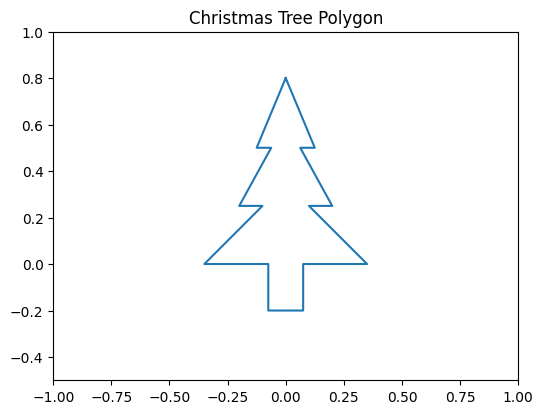

In [28]:
# Sanity check: Plot the tree polygon
plt.figure(figsize=(6, 6))
x, y = tree.polygon.exterior.xy
plt.plot(x, y)
plt.xlim(-1, 1)
plt.ylim(-0.5, 1)
plt.gca().set_aspect('equal', adjustable='box') 
plt.title('Christmas Tree Polygon')
plt.show()

### 4.3 Tree Operators

* This is to perform the tree transformations and rotations about the centroids

In [11]:
def transform_tree(base_polygon, x, y, deg):
    """
    Rotate (about centroid) then translate a tree polygon.
    """
    poly = affinity.rotate(
        base_polygon,
        deg,
        origin='centroid',
        use_radians=False
    )
    poly = affinity.translate(poly, xoff=x, yoff=y)
    return poly


## 5. Feasibility Engine

### 5.1 Overlap Checking

* This is a sanity check to ensure the trees do not overlap in the square

In [26]:
def has_overlap(placed_polygons):
    """
    Return True if any placed polygons overlap
    """
    for i, poly in enumerate(placed_polygons):
        for j, other in enumerate(placed_polygons):
            if i != j and poly.intersects(other):
                return True
    return False

### 5.2 Bounding Square Computation

* This is the core decision logic for the square

In [32]:
def bounding_square_side(placed_polygons):
    """
    Compute side length s of minimal axis-aligned square
    bounding all polygons.
    """
    xmin, ymin, xmax, ymax = None, None, None, None
    
    for polygon in placed_polygons:
        x0, y0, x1, y1 = polygon.bounds
        xmin = x0 if xmin is None else min(xmin, x0)
        ymin = y0 if ymin is None else min(ymin, y0)
        xmax = x1 if xmax is None else max(xmax, x1)
        ymax = y1 if ymax is None else max(ymax, y1)

    width = xmax - xmin
    height = ymax - ymin
    s = max(width, height)
    return s

## 6. Baseline Placement Strategy

### 6.1 Naive Feasible Placement

**Goal:**
- Never overlap
- Always inside bounds
- Terrible score is acceptable (for now)

**Example ideas:**

- Grid placement
- Spiral placement
- Line packing

In [24]:
# Place trees on a grid
def place_trees_grid(n, spacing=2.0):
    """
    Place trees on a square grid.
    Guaranteed no overlap if spacing is large enough.
    """
    polys = []
    side = math.ceil(math.sqrt(n))
    
    idx = 0
    for i in range(side):
        for j in range(side):
            if idx >= n:
                break
            x = i * spacing
            y = j * spacing
            poly = transform_tree(tree.polygon, x, y, deg=0.0)
            polys.append(poly)
            idx += 1

    return polys

* Now we call the function to fit the trees

In [27]:
polys = place_trees_grid(25)
has_overlap(polys)


False

## 7. Optimization layer

### 7.1 Objective Function

In [30]:
# Compute puzzle score

def puzzle_score(polygons):
    """
    s^2 / n
    """
    s = bounding_square_side(polygons)
    n = len(polygons)
    return (s ** 2) / n


* Now we calculate the puzzle score for the 25 placed trees

In [33]:
puzzle_score(polys)

3.24

* Lets plot the polygons to see the fit.

### 7.2 Local Improvement Hueristics

In [ ]:
def improve_layout(layout, iterations=1000):
    pass


## 8. Solver Orchestration

In [ ]:
def solve_puzzle(puzzle_id, n):
    layout = place_trees_baseline(n, tree)
    layout = improve_layout(layout)
    return layout

## 9. Evaluation & Diagnostics

### 9.1 Tree Visualization (For Debugging)

In [ ]:
def plot_layout(layout):
    pass

### 9.2 Stress Testing

- n = 1
- n = 200
- Random seeds
- Worst-case geometry

In [ ]:
# Test Layout and Scoring
    


## 10. Submission Generation

### 10.1 Formatting Utilities 

In [ ]:
# Format fuction to submit values as string sXXXXXX

def fmt(val):
    return f"s{val:.6f}"

### 10.2 Submission Builder

In [ ]:
# Creating a database with results


def build_submission(all_puzzles):
    rows = []
    for puzzle_id, layout in all_puzzles.items():
        for i, (x, y, deg) in enumerate(layout):
            rows.append({
                "id": f"{puzzle_id}_{i}",
                "x": fmt(x),
                "y": fmt(y),
                "deg": fmt(deg)
            })
    return pd.DataFrame(rows)


## 11. Experiment Log